# Imports

In [129]:
import csv
import sklearn.linear_model
import sklearn.metrics
import numpy as np
import dataclasses
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets
import typing
import abc

# Data

In [23]:
@dataclasses.dataclass
class Data:
    gdp: np.ndarray
    freedom: np.ndarray
    happiness: np.ndarray

def read_data(path: str) -> Data:
    with open(path) as f:
        reader = csv.reader(f)
        header = next(reader)
        
        gdp_index = header.index("Economy..GDP.per.Capita.")
        freedom_index = header.index("Freedom")
        happiness_index = header.index("Happiness.Score")
        
        gdp_values = []
        freedom_values = []
        happiness_values = []
        
        for row in reader:
            # if row[gdp_index] == "": continue
            # if row[freedom_index] == "": continue
            # if row[happiness_index] == "": continue
            
            gdp_values.append(float("0" if row[gdp_index] == "" else row[gdp_index]))
            freedom_values.append(float("0" if row[freedom_index] == "" else row[freedom_index]))
            happiness_values.append(float("0" if row[happiness_index] == "" else row[happiness_index]))
        
        gdp_array = np.array(gdp_values)
        freedom_array = np.array(freedom_values)
        happiness_array = np.array(happiness_values)
        
        return Data(
            gdp_array,
            freedom_array,
            happiness_array,
        )
        
datas = {
    "v1": read_data("data/v1_world-happiness-report-2017.csv"),
    "v2": read_data("data/v2_world-happiness-report-2017.csv"),
    "v3": read_data("data/v3_world-happiness-report-2017.csv"),
}

In [3]:
@ipywidgets.interact(data_key=list(datas.keys()))
def show_data_plot(data_key):
    data = datas[data_key]
    plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter(data.freedom, data.gdp, data.happiness, "ro")
    ax.set_xlabel("freedom")
    ax.set_ylabel("gdp")
    ax.set_zlabel("happiness")

interactive(children=(Dropdown(description='data_key', options=('v1', 'v2', 'v3'), value='v1'), Output()), _do…

# Solution

In [163]:
def mat_transposed(m: list[list[float]]) -> list[list[float]]:
    m_rows = len(m)
    m_columns = None
    for row in m:
        if m_columns is None:
            m_columns = len(row)
        else:
            assert m_columns == len(row)
    
    mr = []
    for j in range(m_columns):
        mr.append([])
        for i in range(m_rows):
            mr[j].append(m[i][j])
    
    return mr

def mat_mul(
    m1: list[list[float]],
    m2: list[list[float]],
) -> list[list[float]]:
    m1_rows = len(m1)
    m1_columns = None
    for row in m1:
        if m1_columns is None:
            m1_columns = len(row)
        else:
            assert m1_columns == len(row)
    
    m2_rows = len(m2)
    m2_columns = None
    
    for row in m2:
        if m2_columns is None:
            m2_columns = len(row)
        else:
            assert m2_columns == len(row)
            
    assert m1_columns == m2_rows
    same = m1_columns
    
    mr = []
    for i in range(m1_rows):
        mr.append([])
        for j in range(m2_columns):
            mr[i].append(0)
            for k in range(same):
                mr[i][j] += m1[i][k]*m2[k][j]
    
    return mr

def mat_inv(m: list[list[float]]) -> list[list[float]]:
    m_rows = len(m)
    m_columns = None
    for row in m:
        if m_columns is None:
            m_columns = len(row)
        else:
            assert m_columns == len(row)
    
    assert m_rows == m_columns
    
    mr = []
    for i in range(m_rows):
        mr.append([])
        for j in range(m_columns):
            if i == j:
                v = 1
            else:
                v = 0
            mr[i].append(v)
    
    for i in range(m_rows):
        new_row = None
        for j in range(i, m_rows):
            if m[j][i] != 0:
                new_row = j
                break
        
        assert new_row is not None
        assert new_row == i
        
        m[i], m[new_row] = m[new_row], m[i]
        mr[i], mr[new_row] = mr[new_row], mr[i]
        
        divider = m[i][i]
        for j in range(m_columns):
            m[i][j] /= divider
            mr[i][j] /= divider
        
        for j in range(0, m_rows):
            if j == i:
                continue
            if m[j][i] == 0:
                continue
            multiplier = m[j][i]
            for k in range(m_columns):
                m[j][k] -= m[i][k]*multiplier
                mr[j][k] -= mr[i][k]*multiplier
    
    return mr

In [164]:
@dataclasses.dataclass
class Plotter:
    data: Data
    training_data: Data
    validation_data: Data
    regressor: sklearn.linear_model.LinearRegression
    
    def plot(
        self,
        *,
        show_training_data: bool = False,
        show_validation_data: bool = False,
        show_learned_function: bool = False,
        show_validation_predictions: bool = False,
    ):
        plt.figure()

        ax = plt.axes(projection="3d")

        ax.set_xlabel("freedom")
        ax.set_ylabel("gdp")
        ax.set_zlabel("happiness")

        if show_training_data:
            ax.scatter(
                self.training_data.freedom,
                self.training_data.gdp,
                self.training_data.happiness,
                color="red",
                label="training data",
            )
        if show_validation_data:
            ax.scatter(
                self.validation_data.freedom,
                self.validation_data.gdp,
                self.validation_data.happiness,
                color="green",
                label="validation data",
            )
        if show_learned_function:
            xx, yy = np.meshgrid(
                [np.min(self.data.freedom), np.max(self.data.freedom)],
                [np.min(self.data.gdp), np.max(self.data.gdp)],
            )
            wat = np.stack((xx.flat, yy.flat), axis=1)
            z = self.regressor.predict(wat)
            z = z.reshape(xx.shape)
            surf = ax.plot_surface(
                xx, yy, z,
                facecolor="blue",
                edgecolor="black",
                alpha=0.1,
                label="learned function",
            )
            # workaround for matplotlib bug
            surf._facecolors2d = surf._facecolor3d
            surf._edgecolors2d = surf._edgecolor3d
        if show_validation_predictions:
            a = np.stack((self.validation_data.freedom, self.validation_data.gdp), axis=1)
            z = self.regressor.predict(a)
            ax.scatter(
                self.validation_data.freedom,
                self.validation_data.gdp,
                z,
                color="purple",
                label="validation prediction",
            )
        
        plt.legend()
        plt.show()

def numpy_regression(
    X: np.ndarray,
    Y: np.ndarray,
):
    X = np.stack(
        (
            np.full(X.shape[0], 1),
            X[:,0],
            X[:,1],
        ),
        axis=1,
    )
    W = np.dot(
        np.dot(
            np.linalg.inv(
                np.dot(
                    X.transpose(),
                    X,
                )
            ),
            X.transpose(),
        ),
        Y,
    )
    return W

def my_regression(
    X: list[list[float]],
    Y: list[list[float]],
) -> list[list[float]]:
    Xb = []
    for row in X:
        new_row = [1]
        Xb.append(new_row)
        for element in row:
            new_row.append(element)
    
    W = mat_mul(
        mat_mul(
            mat_inv(
                mat_mul(
                    mat_transposed(Xb),
                    Xb,
                )
            ),
            mat_transposed(Xb),
        ),
        [[element] for element in Y],
    )
    
    return W

class Regressor(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def fit(self, independent: np.ndarray, dependent: np.ndarray):
        pass
    
    @abc.abstractmethod
    def predict(self, independent: np.ndarray) -> np.ndarray:
        pass
    
    @property
    @abc.abstractmethod
    def weights(self) -> np.ndarray:
        pass

class ToolRegressor(Regressor):
    def __init__(self):
        self.__regressor = sklearn.linear_model.LinearRegression()
    
    def fit(self, independent: np.ndarray, dependent: np.ndarray):
        self.__regressor.fit(independent, dependent)
    
    def predict(self, independent: np.ndarray) -> np.ndarray:
        return self.__regressor.predict(independent)
    
    @property
    def weights(self) -> np.ndarray:
        return np.array([self.__regressor.intercept_] + self.__regressor.coef_.tolist())

class MyRegressor(Regressor):
    def __init__(self):
        pass
    
    def fit(self, independent: np.ndarray, dependent: np.ndarray):
        weights = my_regression(independent.tolist(), dependent.tolist())
        weights = [a[0] for a in weights]
        self.__weights = weights
    
    def predict(self, independent: np.ndarray) -> np.ndarray:
        prediction = np.zeros(independent.shape[0])
        for i in range(independent.shape[0]):
            prediction[i] += self.__weights[0]
            for j in range(independent.shape[1]):
                prediction[i] += self.__weights[j+1] * independent[i,j]
        return prediction
    
    @property
    def weights(self) -> np.ndarray:
        return np.array(self.__weights)
    
def train(
    data_name: str,
    regressor: Regressor,
):
    name_widget = ipywidgets.HTML(f"<h1>{data_name}</h1>")
    display(name_widget)
    
    data = datas[data_name]
    
    # split training and validation data
    data_len = len(data.happiness)
    training_percentage = 0.80
    training_indexes = np.random.choice(
        np.array(range(data_len)),
        replace=False,
        size=int(data_len*training_percentage)
    )

    training_mask = np.zeros(data_len, dtype=bool)
    training_mask[training_indexes] = True
    validation_mask = ~training_mask

    # training data
    training_data = Data(
        data.gdp[training_mask],
        data.freedom[training_mask],
        data.happiness[training_mask],
    )

    # validation data
    validation_data = Data(
        data.gdp[validation_mask],
        data.freedom[validation_mask],
        data.happiness[validation_mask],
    )

    training_data_independent = np.stack((training_data.freedom, training_data.gdp), axis=1)

    # fit regressor
    regressor.fit(training_data_independent, training_data.happiness)
    
    # calculate error
    validation_data_independent = np.stack((validation_data.freedom, validation_data.gdp), axis=1)
    predicted_happiness = regressor.predict(validation_data_independent)
    error = sklearn.metrics.mean_squared_error(validation_data.happiness, predicted_happiness)
    
    error_widget = ipywidgets.Label(
        f"error = {error}"
    )
    display(error_widget)
    
    # get coefficients
    w0, w1, w2 = regressor.weights
    
    # show regression function
    regression_function_widget = ipywidgets.HTMLMath(
        f"$w_0={w0:.2f}$<br>$w_1={w1:.2f}$<br>$w_2={w2:.2f}$<br>$y={w0:.2f}+{w1:.2f}x_1+{w2:.2f}x_2$"
    )
    display(regression_function_widget)
    
    plotter = Plotter(
        data,
        training_data,
        validation_data,
        regressor,
    )
    
    plotter.plot(
        show_training_data=True,
        show_validation_data=True,
    )
    
    plotter.plot(
        show_training_data=True,
        show_validation_data=True,
        show_learned_function=True,
    )
    
    plotter.plot(
        show_validation_data=True,
        show_validation_predictions=True,
    )

HTML(value='<h1>v1</h1>')

Label(value='error = 0.2334343374368463')

HTMLMath(value='$w_0=2.55$<br>$w_1=2.16$<br>$w_2=1.93$<br>$y=2.55+2.16x_1+1.93x_2$')

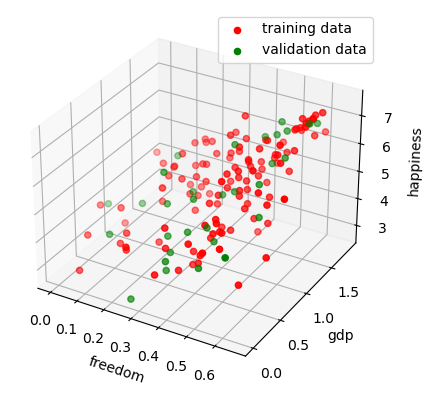

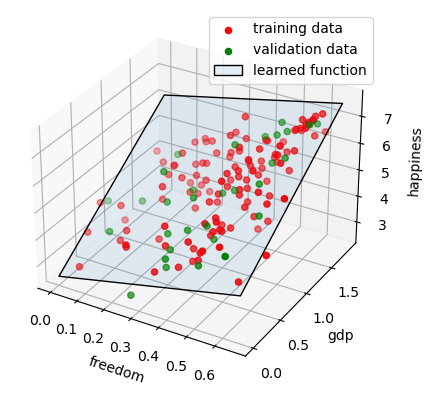

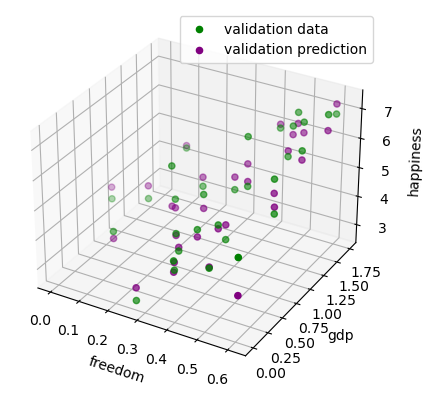

HTML(value='<h1>v1</h1>')

Label(value='error = 0.275828113335849')

HTMLMath(value='$w_0=2.66$<br>$w_1=2.20$<br>$w_2=1.81$<br>$y=2.66+2.20x_1+1.81x_2$')

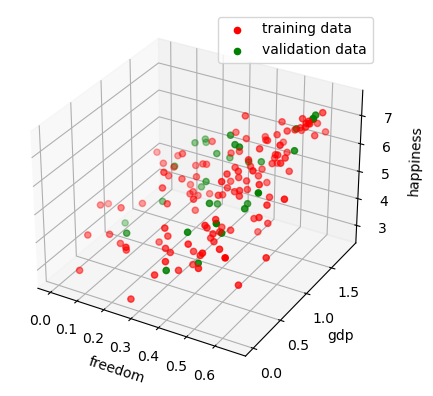

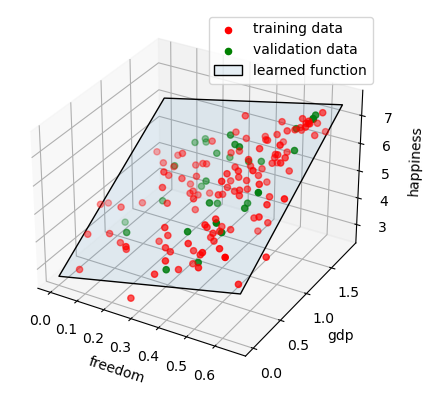

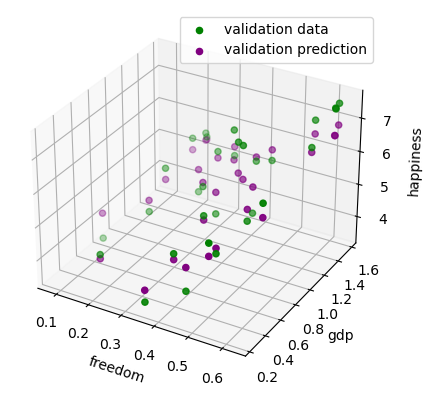

HTML(value='<h1>v2</h1>')

Label(value='error = 0.5904119183458895')

HTMLMath(value='$w_0=3.38$<br>$w_1=-90140917.44$<br>$w_2=45070460.72$<br>$y=3.38+-90140917.44x_1+45070460.72x_…

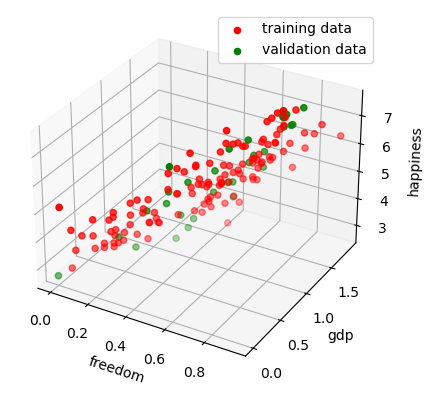

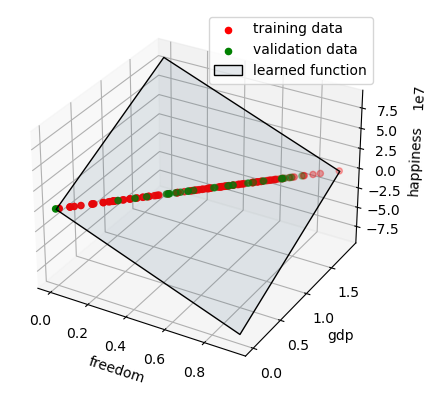

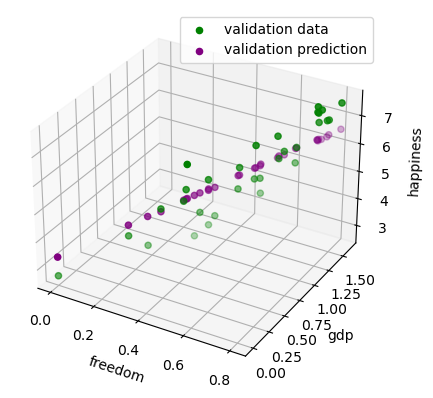

HTML(value='<h1>v2</h1>')

Label(value='error = 0.26478301630170287')

HTMLMath(value='$w_0=3.25$<br>$w_1=33773.83$<br>$w_2=-16884.80$<br>$y=3.25+33773.83x_1+-16884.80x_2$')

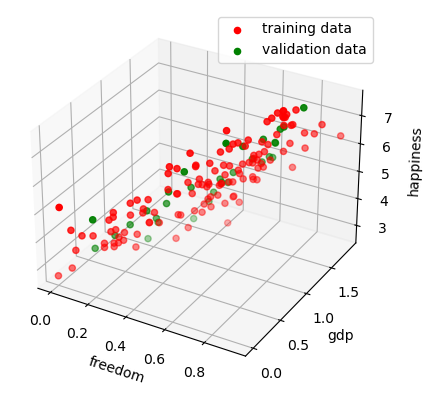

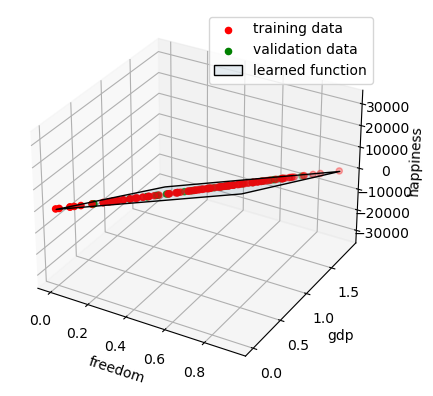

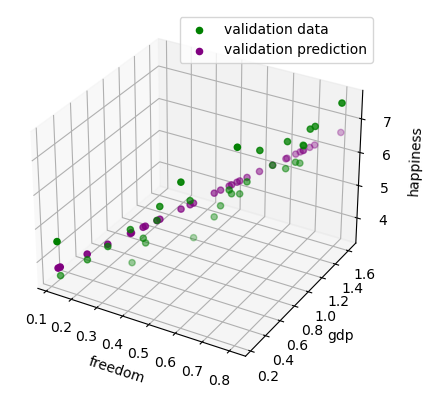

HTML(value='<h1>v3</h1>')

Label(value='error = 0.32442630220190743')

HTMLMath(value='$w_0=2.84$<br>$w_1=2.53$<br>$w_2=1.55$<br>$y=2.84+2.53x_1+1.55x_2$')

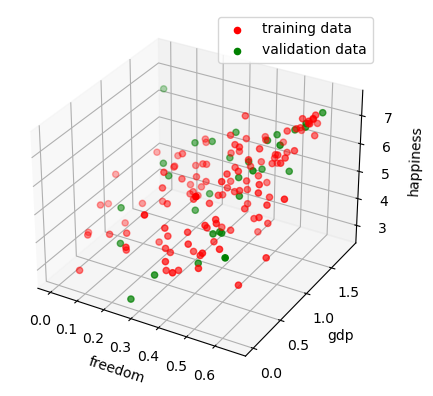

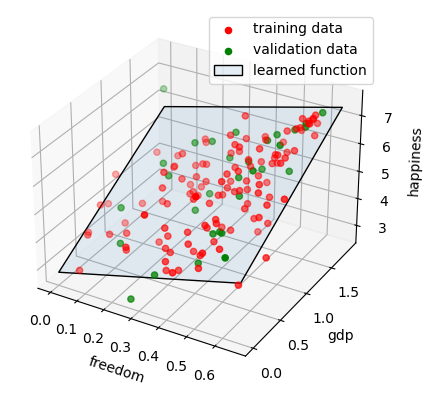

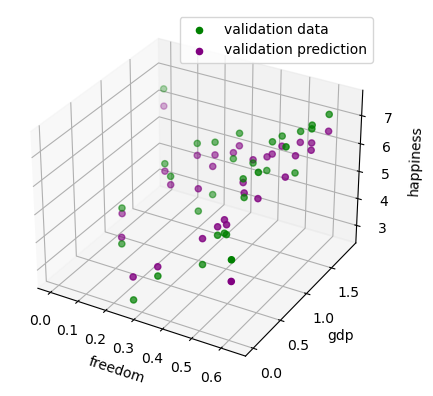

HTML(value='<h1>v3</h1>')

Label(value='error = 0.2463132963250899')

HTMLMath(value='$w_0=2.75$<br>$w_1=2.62$<br>$w_2=1.63$<br>$y=2.75+2.62x_1+1.63x_2$')

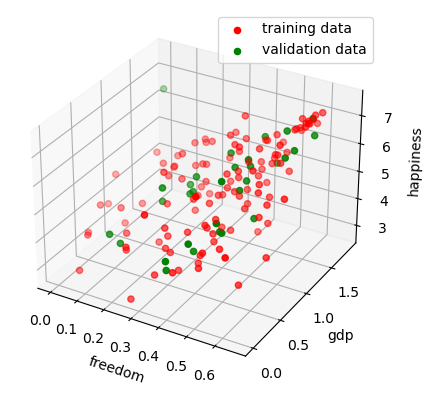

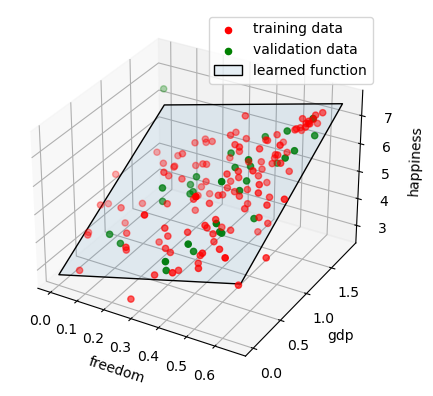

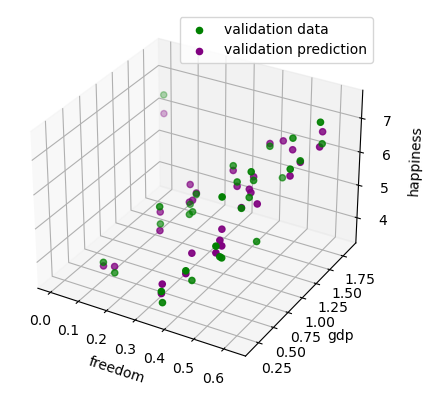

In [167]:
for data_name in datas.keys():
    train(
        data_name,
        ToolRegressor(),
    )
    train(
        data_name,
        MyRegressor(),
    )